**Carga de Sísmica**

*Se vincula con el drive para tomar la sísmica de la carpeta compartida*

Por favor agregar la carpeta compartida llamada "Seismic_Facies" en "Mi Unidad" para poder correr este código

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filename = '/content/drive/MyDrive/ML-NLP/Boonsville Data Set/BOONS-open.sgy'

**Instalación y carga de librerías**

In [ ]:
!pip install segyio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
!pip install pyvista

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 MB 5.3 MB/s eta 0:00:00


In [ ]:
!python -m pip install "dask[complete]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.2 MB/s eta 0:00:00


**Conversión del Cubo a np.array**

In [ ]:
#ESTA PARTE ES IMPORTANTE PARA PODER IMPORTAR pyVista
# setup enviornment for interactive plotting
!apt-get install -qq xvfb
!pip install pyvista panel -q

import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')



### new cell simple plot ###
pn.extension('vtk')  # this needs to be at the top of each cell for some reason

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfonts-encodings.
Preparing to unpack .../4-xfonts-encodings_1%3a1.0.5-0ubuntu2_all.deb ...
Unpacking xfonts-encodings (1:1.0.5-0ubuntu2) ...
Selecting previously unselected package xfonts-util

In [ ]:
import numpy as np
import segyio
array_3d = np.array(segyio.tools.cube(filename))
array_3d = np.ascontiguousarray(array_3d, 'float32')

print("Original cube dimension:", array_3d.shape)

Original cube dimension: (97, 133, 2001)


In [ ]:
import os
os.environ["keras_backend"]= "tensorflow"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
class LogNormalMixtureSampling(layers.Layer):
    def __init__(self, num_components, latent_dim, **kwargs):
        super(LogNormalMixtureSampling, self).__init__(**kwargs)
        self.num_components = num_components
        self.latent_dim = latent_dim

    def call(self, inputs):
        mean, log_var, logits = inputs
        batch = tf.shape(mean)[0]

        # Reshape mean and log_var to have shape (batch, num_components, latent_dim)
        mean = tf.reshape(mean, (batch, self.num_components, self.latent_dim))
        log_var = tf.reshape(log_var, (batch, self.num_components, self.latent_dim))

        # Muestreo de la mezcla
        epsilon = tf.random.normal(shape=(batch, self.num_components, self.latent_dim))
        z = mean + tf.exp(0.5 * log_var) * epsilon
        lognormal_samples = tf.exp(z)  # Transformar a lognormal

        # Selección de componente
        component_selection = tf.random.categorical(logits, 1)
        component_selection = tf.squeeze(component_selection, axis=-1)
        component_selection = tf.one_hot(component_selection, self.num_components)
        component_selection = tf.expand_dims(component_selection, axis=-1)

        # Combinar muestras
        weighted_samples = tf.reduce_sum(lognormal_samples * component_selection, axis=1)

        return weighted_samples



In [ ]:
latent_dim = 2
num_components = 2  # Número de componentes en la mezcla

encoder_inputs = keras.Input(shape=(97, 133, 1))
x = layers.Conv2D(24, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
mean = layers.Dense(num_components * latent_dim, name="mean")(x)
log_var = layers.Dense(num_components * latent_dim, name="log_var")(x)
logits = layers.Dense(num_components, name="logits")(x)
z = LogNormalMixtureSampling(num_components, latent_dim)([mean, log_var, logits])

encoder = keras.Model(encoder_inputs, [mean, log_var, logits, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 97, 133, 1)]         0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 49, 67, 24)           240       ['input_4[0][0]']             
                                                                                                  
 flatten_2 (Flatten)         (None, 78792)                0         ['conv2d_2[0][0]']            
                                                                                                  
 dense_3 (Dense)             (None, 32)                   2521376   ['flatten_2[0][0]']           
                                                                                            

In [ ]:
# Definición del decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(97 * 133, activation="relu")(latent_inputs)
x = layers.Reshape((97, 133, 1))(x)  # Reshape para coincidir con la salida de Conv2DTranspose
x = layers.Conv2DTranspose(24, 3, activation="relu", strides=1, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 12901)             38703     
                                                                 
 reshape_1 (Reshape)         (None, 97, 133, 1)        0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 97, 133, 24)       240       
 Transpose)                                                      
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 97, 133, 1)        217       
 Transpose)                                                      
                                                                 
Total params: 39160 (152.97 KB)
Trainable params: 39160 (15

In [ ]:
# Clase VAE adaptada
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean, log_var, logits, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Pérdida de reconstrucción
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction),
                    axis=(1, 2)
                )
            )

            # Pérdida KL
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
            )

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

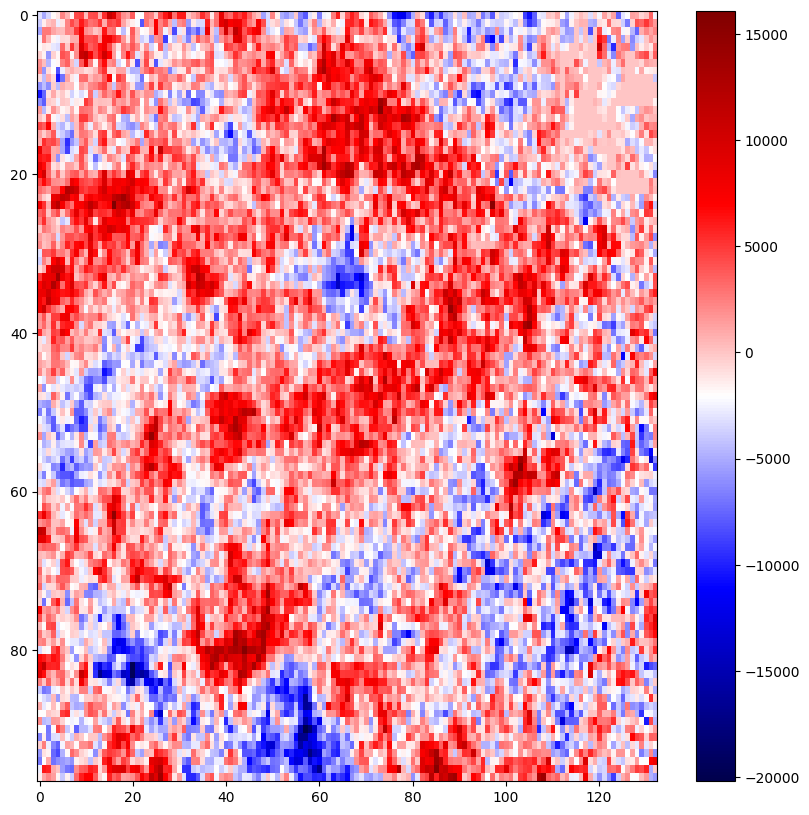

In [ ]:
import matplotlib.pyplot as plt
time_slice = array_3d[:,:,420]
plt.figure(figsize=(10,10))
plt.imshow(time_slice,aspect='auto',cmap='seismic')
plt.colorbar(label='')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
scaled_data = np.array([array_3d[:,:,i] for i in range(250,2001)])
mean = np.mean(scaled_data,axis=(0,1,2))
std_dev = np.std(scaled_data,axis=(0,1,2))
scaled_data = (scaled_data - mean)/(np.nanmax(scaled_data)-np.nanmin(scaled_data))*8
scaled_data = np.expand_dims(scaled_data,-1).astype('float32')

In [ ]:
np.mean(scaled_data,axis=(0,1,2))

array([-4.2087533e-09], dtype=float32)

In [ ]:
np.std(scaled_data,axis=(0,1,2))

array([0.4198261], dtype=float32)

In [ ]:
scaled_data.shape

(1751, 97, 133, 1)

In [ ]:
scaled_data[0].shape

(97, 133, 1)

In [ ]:
vae = VAE(encoder,decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001,clipvalue=1.0))
vae.fit(scaled_data,epochs=10,batch_size=64)

Epoch 1/10


28/28 [==============================] - 36s 1s/step - loss: 2402.5432 - reconstruction_loss: 2295.9382 - kl_loss: 99.2921
Epoch 2/10
28/28 [==============================] - 33s 1s/step - loss: 2337.6457 - reconstruction_loss: 2282.3701 - kl_loss: 77.8325
Epoch 3/10
28/28 [==============================] - 32s 1s/step - loss: 2347.6612 - reconstruction_loss: 2286.7898 - kl_loss: 69.6062
Epoch 4/10
28/28 [==============================] - 34s 1s/step - loss: 2263.4056 - reconstruction_loss: 2266.1099 - kl_loss: 66.3366
Epoch 5/10
28/28 [==============================] - 33s 1s/step - loss: 2364.4227 - reconstruction_loss: 2272.3679 - kl_loss: 59.0637
Epoch 6/10
28/28 [==============================] - 31s 1s/step - loss: 2266.3128 - reconstruction_loss: 2238.7424 - kl_loss: 54.8007
Epoch 7/10
28/28 [==============================] - 30s 1s/step - loss: 2307.7450 - reconstruction_loss: 2267.5037 - kl_loss: 50.4681
Epoch 8/10
28/28 [==============================] - 30s 1s/step - loss: 2

Text(0, 0.5, '')

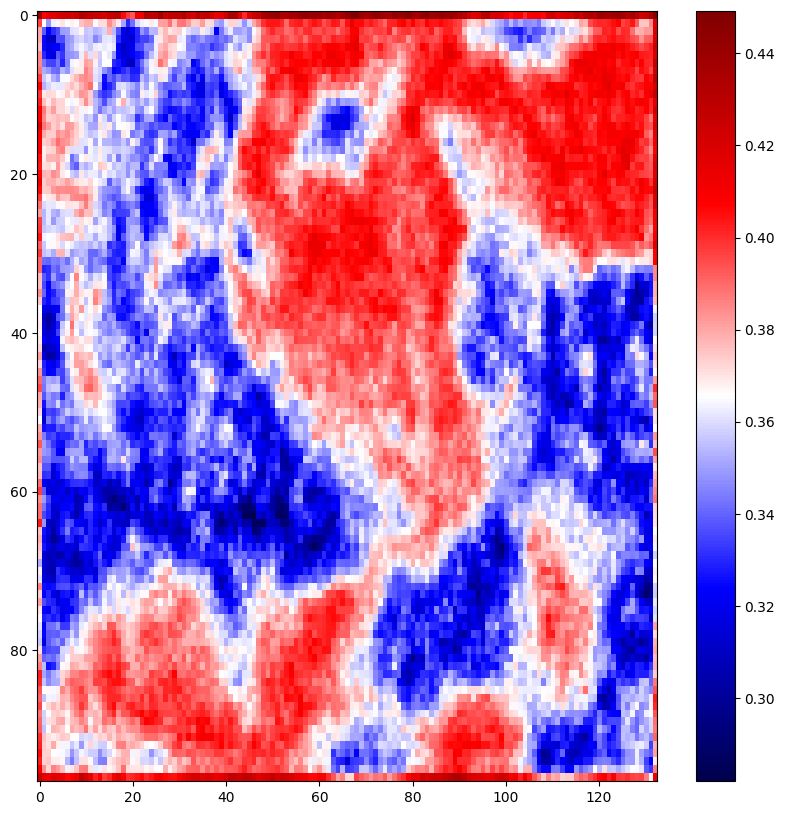

In [ ]:
sample = np.array([[3,4]])
x_decoded = vae.decoder.predict(sample,verbose=0)
plt.figure(figsize=(10,10))
plt.imshow(x_decoded[0].reshape(97,133),aspect='auto',cmap='seismic')
plt.colorbar(label='')
plt.xlabel('')
plt.ylabel('')

In [ ]:
with segyio.open(filename) as f:
  print('Inline range from', min(f.ilines), 'to', max(f.ilines))
  print('Crossline range from', min(f.xlines), 'to', max(f.xlines))
  data = f.trace.raw[:]
  clip_percentile = 99
  vm = np.percentile(data, clip_percentile)

f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}'

Inline range from 105 to 201
Crossline range from 74 to 206


'The 99th percentile is 37393; the max amplitude is 149036'

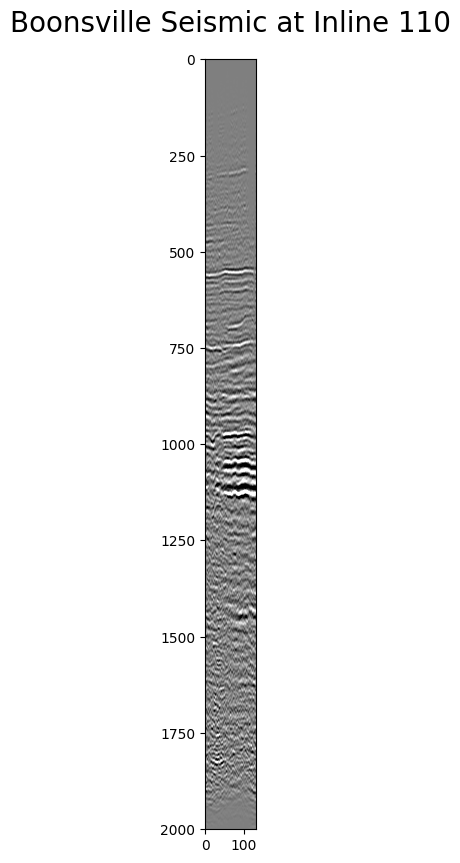

In [ ]:
import matplotlib.pyplot as plt
with segyio.open(filename) as f:
    inline_number = 110
    inline_slice = f.iline[inline_number]
    plt.figure(figsize=(20, 10))
    plt.title('Boonsville Seismic at Inline {}'.format(inline_number), size=20, pad=20)
    plt.imshow(inline_slice.T, cmap="gray", vmin=-vm, vmax=vm) # other cmap = "RdBu"
    plt.show()



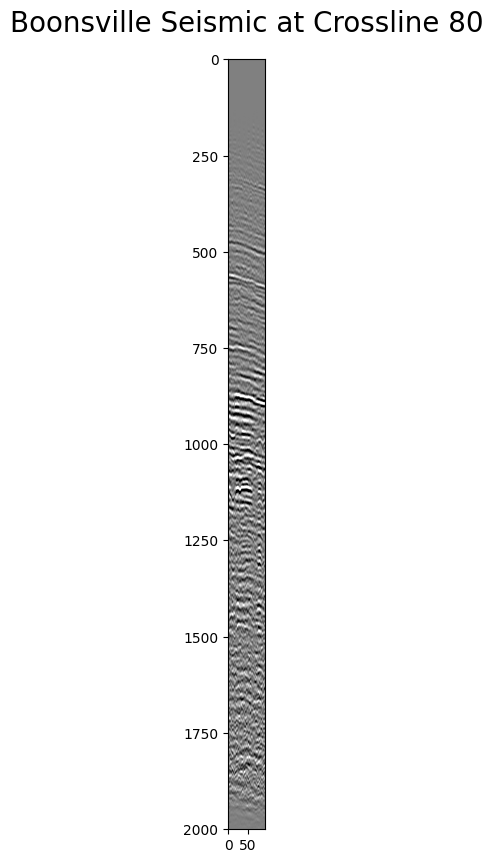

In [ ]:
with segyio.open(filename) as f:
    xline_number = 80
    xline_slice = f.xline[xline_number]
    plt.figure(figsize=(20, 10))
    plt.title('Boonsville Seismic at Crossline {}'.format(xline_number), size=20, pad=20)
    plt.imshow(xline_slice.T, cmap="gray", vmin=-vm, vmax=vm)
    plt.show()


In [ ]:
plt.imshow(seismic[:,500,:], aspect='auto', cmap='gray')
plt.colorbar()
plt.show()

(133, 2001)

In [ ]:
import pyvista as pv
import numpy as np

# Create two planes
plane1 = pv.Plane(center=(0, 0, 0), direction=(1, 0, 0))
plane2 = pv.Plane(center=(0, 0, 0), direction=(0, 1, 0))

# Rotate the planes to intersect
angle = 45  # Angle in degrees for intersection
plane2.rotate_y(angle)

# Create a new PyVista plotter
plotter = pv.Plotter()

# Add the planes to the plotter
plotter.add_mesh(plane1, color='red')
plotter.add_mesh(plane2, color='green')

# Show the plot
plotter.show()

In [ ]:
def inspect_seismic_cubes(file_name):
    segy_file = segyio.open(file_name)
    iline_start = int(segy_file.ilines[0])
    iline_end = int(segy_file.ilines[-1])
    iline_offset = int(segy_file.ilines[1] - segy_file.ilines[0])

    xline_start = int(segy_file.xlines[0])
    xline_end = int(segy_file.xlines[-1])
    xline_offset = int(segy_file.xlines[1] - segy_file.xlines[0])

    time_start = int(segy_file.samples[0])
    time_end = int(segy_file.samples[-1])
    time_offset = int(segy_file.samples[1] - segy_file.samples[0])

    print("File: {} \n"
          "Inline range: [{}, {}]. Offset: {}\n"
          "Crossline range: [{}, {}]. Offset: {}\n"
          "Time range: [{}, {}]. Offset: {}".format(os.path.basename(file_name),
                                                       iline_start, iline_end, iline_offset,
                                                       xline_start, xline_end, xline_offset,
                                                       time_start, time_end, time_offset))
    metadata = {
        'inline': (iline_start, iline_end, iline_offset),
        'crossline': (xline_start, xline_end, xline_offset),
        'time': (time_start, time_end, time_offset)
    }

    return metadata

metadata = inspect_seismic_cubes(filename)

File: BOONS-open.sgy 
Inline range: [105, 201]. Offset: 1
Crossline range: [74, 206]. Offset: 1
Time range: [0, 2000]. Offset: 1


/usr/local/lib/python3.10/dist-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


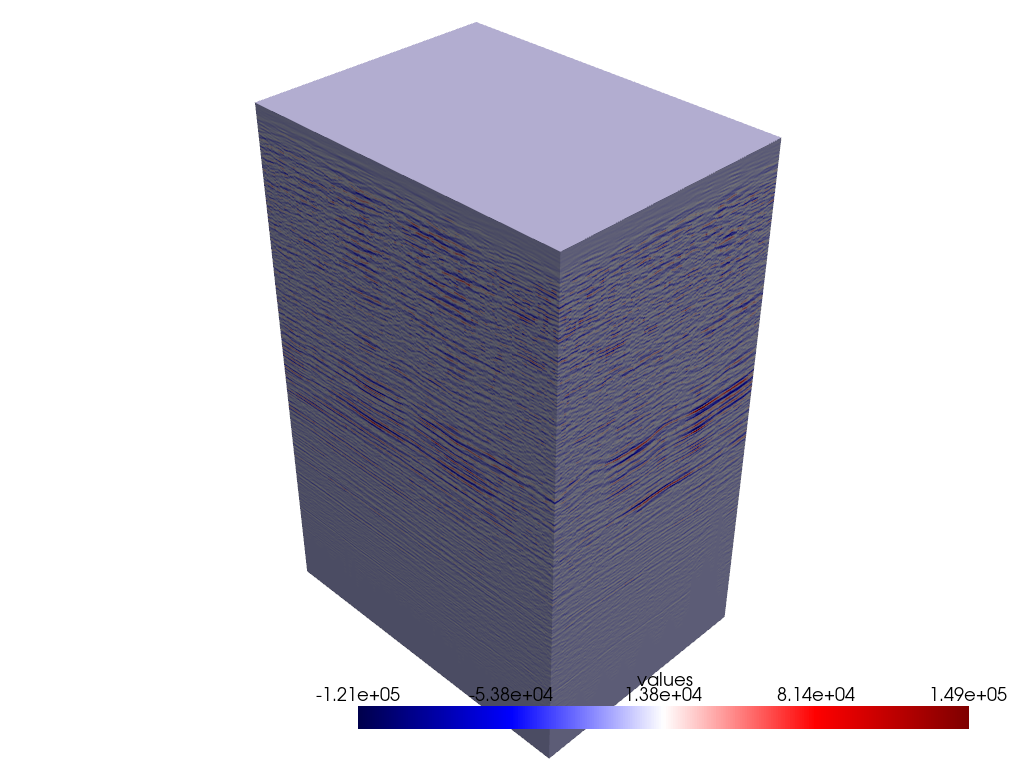

In [ ]:
import pyvista as pv
values = array_3d
values.shape

# Create the spatial reference
grid = pv.ImageData()

# Set the grid dimensions: shape + 1 because we want to inject our values on
#   the CELL data
grid.dimensions = np.array(values.shape) + 1

# Edit the spatial reference
grid.origin = (100, 33, 55.6)  # The bottom left corner of the data set
grid.spacing = (1, 1, .1)  # These are the cell sizes along each axis

# Add the data values to the cell data
grid.cell_data["values"] = values.flatten(order="F")  # Flatten the array

# Now plot the grid
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(grid, scalars="values", cmap="seismic")  # Asignar 'Amplitudes' como escalares y colormap 'viridis'
plotter.show()


In [ ]:
import pyvista as pv
import numpy as np

# Create two planes
plane1 = pv.Plane(center=(0, 0, 0), direction=(1, 0, 0))
plane2 = pv.Plane(center=(0, 0, 0), direction=(0, 1, 0))

# Rotate the planes to intersect
angle = 45  # Angle in degrees for intersection
plane2.rotate_y(angle)

# Create a new PyVista plotter
plotter = pv.Plotter()

# Add the planes to the plotter
plotter.add_mesh(plane1, color='red')
plotter.add_mesh(plane2, color='green')

# Show the plot
plotter.show()

/usr/local/lib/python3.10/dist-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


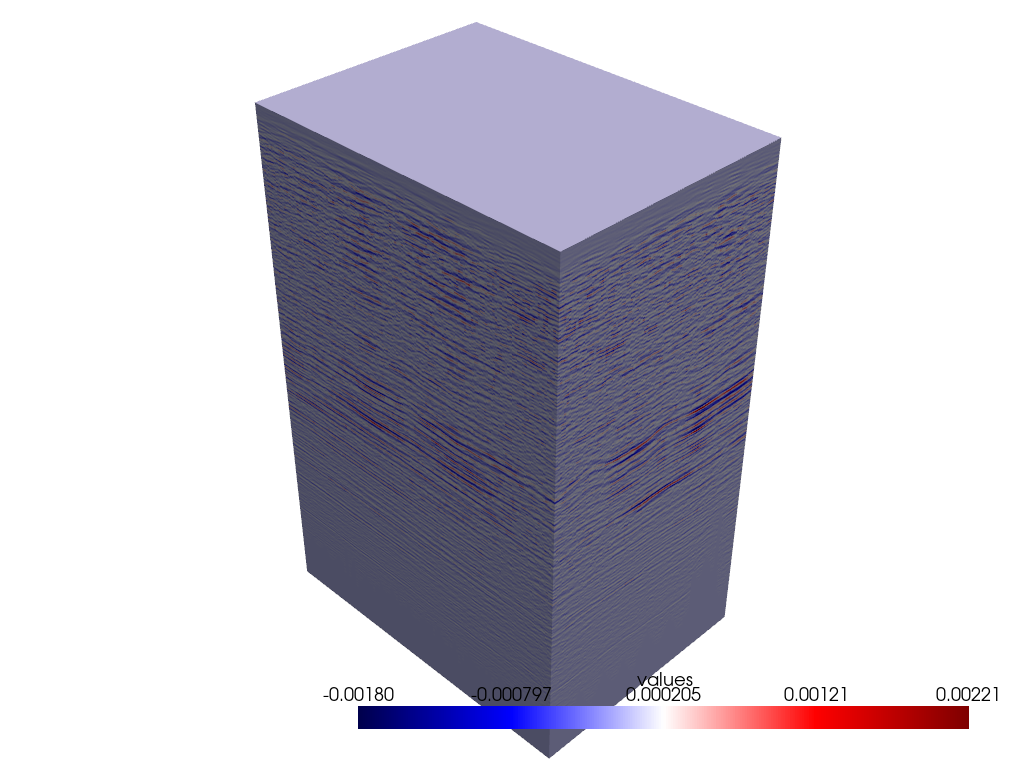

In [ ]:
from sklearn.preprocessing import normalize

values = array_3d

# Normalizar los valores entre 0 y 1 a lo largo del último eje (2001)
normalized_values = normalize(values.flatten(order="F").reshape(-1, 1), axis=0).reshape(values.shape, order="F")

# Crear el objeto de datos de imagen (ImageData) para el cubo
grid = pv.ImageData()

# Establecer las dimensiones del cubo a partir del shape de los valores + 1
grid.dimensions = np.array(values.shape) + 1

# Establecer el origen y el espaciado del cubo
grid.origin = (100, 33, 55.6)  # Origen del cubo en coordenadas
grid.spacing = (1, 1, .1)  # Espaciado del cubo en cada eje

# Añadir los valores normalizados al cubo como datos de celda ('CELL data')
grid.cell_data["values"] = normalized_values.flatten(order="F")  # Añadir valores normalizados

# Crear el visualizador para mostrar el cubo
plotter = pv.Plotter(notebook=True)

# Añadir el cubo al visualizador con la escala de colores 'bwr' (blue-white-red)
plotter.add_mesh(grid, scalars="values", cmap="seismic")

# Mostrar el visualizador con el cubo y la escala de colores
plotter.show()


In [ ]:
import os
import sys
import time
import numpy as np


import dask.array as da
import dask.dataframe as ddf

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Dict, List, Tuple, Callable

**Atributos Sísmicos**

*Se extrae de la sísmica los atributos que sean linealmente independientes*

Esta parte del código es extraída del repositiorio [Energy-sdk](https://github.com/otavioon/energy-sdk/blob/master/rapids_seismic_facies/Unsupervised_Seismic_Facies_DGXA100.ipynb)

In [ ]:
def run_attributes(input_cube, attributes: List[Tuple[str, Callable, Dict[str, str]]]):
    datas = [attr_func(input_cube, **attr_kwargs).flatten() for _, attr_func, attr_kwargs in attributes]
    datas = da.stack(datas, axis=1)
    return ddf.from_dask_array(datas, columns=[attr_name for attr_name, _, _ in attributes])

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ML-NLP/d2geo')

from attributes.CompleTrace import ComplexAttributes
#from attributes.CompleTrace_kernel import ComplexAttributes
from attributes.SignalProcess import SignalProcess



In [ ]:
complex_att = ComplexAttributes()
signal_process = SignalProcess()

In [ ]:
def amplitude_arr(input_cube):
    return da.from_array(input_cube)

In [ ]:
funcs = [
    ('Amplitude', amplitude_arr, {}),
    ('Envelope', complex_att.envelope, {}),
    ('Instantaneous Phase', complex_att.instantaneous_phase, {}),
    ('Cosine Instantaneous Phase', complex_att.cosine_instantaneous_phase, {}),
    ('Relative Amplitude Change', complex_att.relative_amplitude_change, {}),
    ('Amplitude Acceleration', complex_att.amplitude_acceleration, {}),
    ('Instantaneous Bandwidth', complex_att.instantaneous_bandwidth, {})
]

dataframe = run_attributes(array_3d, funcs).compute()
dataframe.tail()

,Amplitude,Envelope,Instantaneous Phase,Cosine Instantaneous Phase,Relative Amplitude Change,Amplitude Acceleration,Instantaneous Bandwidth
25814896,14.139205,4329.156250,-89.812866,180.0,629.516113,287.172363,100.190605
25814897,-10.465938,4738.962402,-90.126534,180.0,1082.502563,317.902588,172.285629
25814898,1.385469,6494.161133,-89.987778,180.0,1265.321289,1164.504395,201.382141
25814899,0.679761,7269.604980,-89.994644,180.0,3411.511475,879.234131,542.958923
25814900,0.000055,13317.184570,-90.000000,180.0,3023.789551,-193.860947,481.251068


**Mapas Auto-Organizados (SOM)**

In [ ]:
!pip install sklearn_som

In [ ]:
from sklearn_som.som import SOM

In [ ]:
features = [
'Amplitude','Envelope','Instantaneous Phase',
         'Cosine Instantaneous Phase','Relative Amplitude Change','Amplitude Acceleration',
             'Instantaneous Bandwidth'
]

X = dataframe.loc[:, features].values

In [ ]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

In [ ]:
som = SOM(m=1, n=6, dim=len(features), random_state=42)
som.fit(X, epochs=1)

In [ ]:
dataframe['facies'] = som.predict(X)

/usr/local/lib/python3.10/dist-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


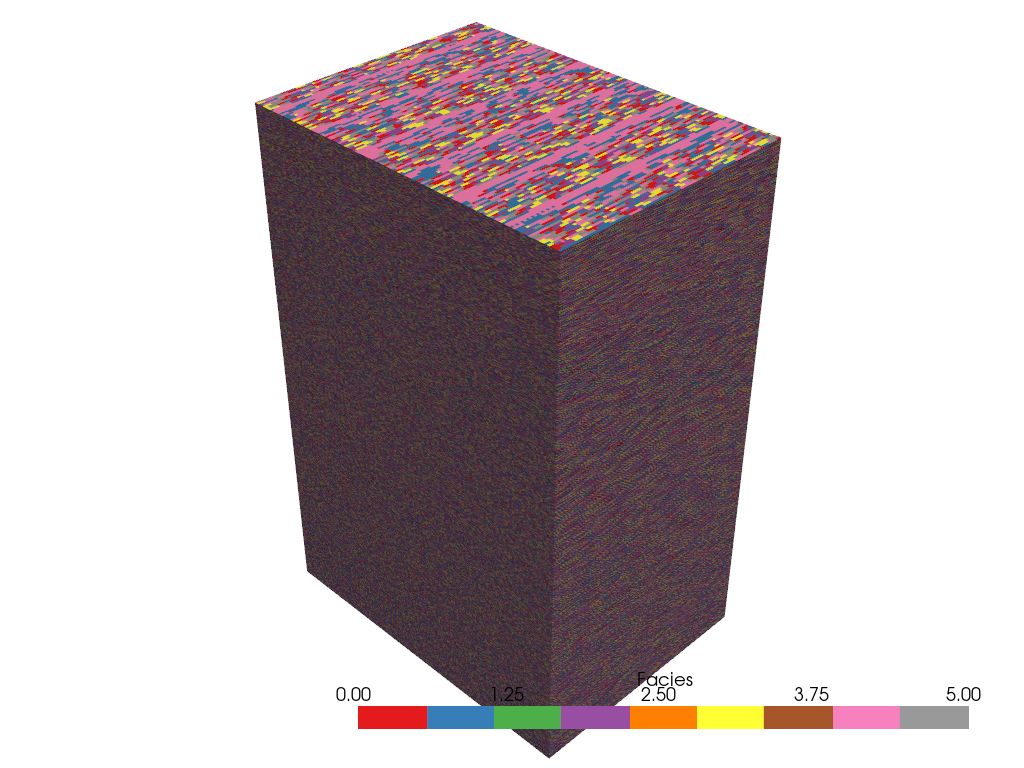

In [ ]:
import pyvista as pv
values = array_3d
values.shape
facies = dataframe.facies.values
# Create the spatial reference
grid = pv.ImageData()

# Set the grid dimensions: shape + 1 because we want to inject our values on
#   the CELL data
grid.dimensions = np.array(values.shape) + 1

categories_flat = facies.flatten(order="F")

# Edit the spatial reference
grid.origin = (100, 33, 55.6)  # The bottom left corner of the data set
grid.spacing = (1, 1, .1)  # These are the cell sizes along each axis

# Add the data values to the cell data
grid.cell_data["values"] = values.flatten(order="F")  # Flatten the array
grid.cell_data["Facies"] = categories_flat.astype(int)

# Now plot the grid
plotter = pv.Plotter(notebook=True)
#plotter.add_mesh(grid, scalars="Values", cmap="viridis", clim=[values.min(), values.max()])  # Colormap para los valores numéricos
plotter.add_mesh(grid, scalars="Facies",cmap='Set1',clim=[facies.min(), facies.max()], show_scalar_bar=True)  # Categorías como colores
plotter.show(interactive=True)
